<a href="https://colab.research.google.com/github/virf96/Basico/blob/main/Perfilamiento_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen 1

## Preparación de ambiente

### Carga de módulos

In [2]:
pip install geopandas

     |████████████████████████████████| 1.0MB 10.8MB/s 
     |████████████████████████████████| 6.5MB 46.3MB/s 
     |████████████████████████████████| 14.8MB 219kB/s 


In [6]:
pip install keplergl

     |████████████████████████████████| 7.9MB 7.1MB/s 
  Created wheel for keplergl: filename=keplergl-0.2.2-py2.py3-none-any.whl size=15942747 sha256=07d5d370ad6255fda48bc7441e22bac97ebedfadae62e70a5a932746435fdea6
  Stored in directory: /root/.cache/pip/wheels/0e/78/c4/04ea0dbf6447ad708393751cd6ea453fb682f4c1c734f2247b
Successfully built keplergl


In [7]:
import pandas as pd
import cufflinks as cf
import geopandas as gpd
from keplergl import KeplerGl
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering

cf.go_offline()
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

### Funciones relevantes

In [8]:
def pivot_categories(df, cluster_column, categories):
    aux = df.copy()
    aux["dum"] = 1
    for i, col in enumerate(categories):
        agg_data = aux[[cluster_column, col, "dum"]].pivot_table(index = cluster_column, columns=col, aggfunc="sum", fill_value=0)
        agg_data.columns = [f"{col}_{x}" for x in agg_data.columns.droplevel(0)]
        for col in agg_data:
            agg_data[col] /= agg_data.sum(axis=1)
        if i == 0:
            final = agg_data.copy()
        else:
            final = final.merge(agg_data, left_index = True, right_index = True, how = "inner")
    return final

## Datos

### Lectura de sets

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
users = pd.read_csv("/content/drive/MyDrive/datasets/users.csv")
users_cuisine = pd.read_csv("/content/drive/MyDrive/datasets/usercuisine.csv")
rating = pd.read_csv("/content/drive/MyDrive/datasets/ratings.csv")
restaurants = pd.read_csv("/content/drive/MyDrive/datasets/restaurants.csv")
parking = pd.read_csv("/content/drive/MyDrive/datasets/parking.csv")
restaruants_cuisine = pd.read_csv("/content/drive/MyDrive/datasets/cuisine.csv")
user_payment = pd.read_csv("/content/drive/MyDrive/datasets/userpayment.csv")
restaurant_payment = pd.read_csv("/content/drive/MyDrive/datasets/payment_methods.csv")
hours = pd.read_csv("/content/drive/MyDrive/datasets/hours.csv")

In [11]:
rating.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userID          1161 non-null   object
 1   placeID         1161 non-null   int64 
 2   rating          1161 non-null   int64 
 3   food_rating     1161 non-null   int64 
 4   service_rating  1161 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 106.7 KB


### EDA

#### Usuarios

In [12]:
#Podemos notar 3 agrupaciones claras mediante la latitud y longitud de los puntos esto nos lleva a pensar que están en la misma geolocalización
users[["userID", "latitude", "longitude"]].set_index("userID").iplot(kind = "scatter", x="latitude", y = "longitude", mode = "markers")

In [38]:
# Observamos las ubicaciones de los elementos
map_1 = KeplerGl(height=500)
gdf = gpd.GeoDataFrame(users, geometry=gpd.points_from_xy(users.latitude, users.longitude))
map_1.add_data(data=gdf, name="Usuarios")
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Usuarios': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20…

#### Restaurantes

In [14]:
map_1 = KeplerGl(height=500)
gdf = gpd.GeoDataFrame(restaurants, geometry=gpd.points_from_xy(restaurants.latitude, restaurants.longitude))
map_1.add_data(data=gdf, name="Restaurantes")
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Restaurantes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

#### Rating

In [39]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [15]:
#Observamos que la mitad de la población califica de mala manera el servicio
#Tenemos 1,161,000 establecimientos
rating.describe()

,placeID,rating,food_rating,service_rating
count,"1,161.00","1,161.00","1,161.00","1,161.00"
mean,"134,192.04",1.20,1.22,1.09
std,"1,100.92",0.77,0.79,0.79
min,"132,560.00",0.00,0.00,0.00
25%,"132,856.00",1.00,1.00,0.00
50%,"135,030.00",1.00,1.00,1.00
75%,"135,059.00",2.00,2.00,2.00
max,"135,109.00",2.00,2.00,2.00


In [16]:
#Hay más personas que califican de buena manera el servicio
rating["rating"].value_counts()

2    486
1    421
0    254
Name: rating, dtype: int64

In [17]:
#Observamos las veces que calificaron el estblecimiento
# El promedio de rating que tiene
#El promedio de rating en comida
# El promedio de rating en servicio
rating.groupby("userID").agg({"placeID": "count", "rating": "mean", "food_rating": "mean", "service_rating": "mean", })

,placeID,rating,food_rating,service_rating
userID,,,,
U1001,9,1.11,1.22,1.22
U1002,10,1.40,1.40,1.00
U1003,13,1.62,1.69,1.46
U1004,8,1.88,1.88,1.75
U1005,9,1.33,1.44,1.00
U1006,11,1.36,1.18,1.64
U1007,9,0.89,1.11,0.67
U1008,9,1.11,1.22,0.89
U1009,11,1.36,1.27,1.09


In [18]:
#Observamos la en número de veces que fueron evaluados y el promedio de esa evaliaciones por establecimiento
rating.groupby("placeID").agg(["count", "mean"]).sort_values(by=("rating", "count"))

rating      food_rating      service_rating     
         count mean       count mean          count mean
placeID                                                 
135011       3 1.33           3 1.33              3 1.33
132668       3 1.00           3 1.00              3 1.00
134975       3 1.67           3 1.33              3 1.33
132766       3 0.67           3 1.00              3 0.67
135016       3 1.00           3 1.33              3 1.00
132717       3 1.33           3 1.33              3 1.00
135033       4 0.75           4 0.75              4 1.25
135018       4 1.50           4 1.75              4 1.50
135040       4 0.25           4 0.25              4 0.25
135013       4 1.75           4 2.00              4 1.75
135044       4 1.25           4 1.25              4 1.00
135000       4 1.25           4 1.00              4 1.00
134987       4 1.00           4 0.50              4 1.00
134976       4 1.75           4 1.75              4 1.00
135073       4 1.50           4 1.50              4 1.00
132937       4 1.50           4 1.00              4 1.00
132877       4 0.75           4 0.75              4 1.00
135074       4 1.75           4 1.75              4 1.75
132773       4 1.50           4 1.25              4 1.75
135035       4 1.50           4 1.50              4 1.50
132560       4 0.50           4 1.00              4 0.25
134992       4 1.00           4 1.50              4 1.00
135109       4 1.00           4 1.25              4 0.75
132626       4 1.25           4 1.00              4 1.00
132654       4 0.25           4 0.25              4 0.25
132583       4 1.00           4 1.00              4 1.25
132564       4 1.25           4 1.25              4 1.50
132706       4 0.75           4 1.25              4 1.00
132561       4 0.75           4 1.00              4 1.00
132667       4 1.25           4 2.00              4 1.25
132715       4 1.00           4 1.00              4 0.50
134983       5 1.00           5 1.00              5 1.20
132870       5 0.60           5 1.00              5 0.40
132885       5 0.60           5 0.60              5 0.40
132866       5 1.40           5 1.40              5 1.40
132665       5 0.80           5 0.80              5 1.00
135034       5 2.00           5 2.00              5 1.60
132858       5 0.80           5 1.40              5 0.60
132660       5 1.40           5 1.40              5 1.00
132594       5 0.60           5 1.20              5 0.60
135049       5 1.00           5 0.60              5 1.00
132955       5 2.00           5 1.80              5 1.80
132846       5 1.40           5 1.40              5 1.20
132845       5 0.80           5 0.60              5 0.80
132609       5 0.60           5 0.60              5 0.60
132925       5 1.00           5 1.20              5 1.20
132755       5 1.80           5 2.00              5 1.60
134999       5 1.60           5 1.60              5 1.60
132958       6 1.67           6 1.50              6 1.50
135088       6 1.00           6 1.17              6 1.00
132584       6 1.33           6 1.50              6 1.00
132630       6 1.17           6 1.17              6 1.00
132613       6 1.17           6 1.33              6 1.00
132608       6 1.00           6 1.17              6 0.83
132663       6 0.50           6 0.50              6 0.67
135080       6 1.00           6 1.00              6 1.00
132922       6 1.83           6 1.50              6 1.83
132767       6 1.17           6 1.33              6 1.17
132884       6 1.17           6 1.17              6 1.17
135019       6 1.33           6 1.50              6 0.83
132869       6 1.17           6 1.33              6 1.17
135048       6 1.00           6 1.33              6 1.33
132854       6 1.33           6 1.67              6 1.17
132847       6 1.17           6 1.33              6 0.67
135055       7 1.71           7 1.71              7 1.71
132861       7 1.43           7 1.57              7 1.43
132851       7 1.43           7 1.00              7 1.00
135001       7 1.4

#### User payment

In [19]:
#Distribución de medios de pago
user_payment["Upayment"].value_counts()

cash                   131
bank_debit_cards        22
VISA                    17
MasterCard-Eurocard      4
American_Express         3
Name: Upayment, dtype: int64

#### User cuisine

In [20]:
#Hay demasiadas etiquetas diferentes, bucaremos hacer representativas las menos representativas
users_cuisine["Rcuisine"].value_counts(True)

Mexican                0.29
American               0.03
Cafeteria              0.03
Pizzeria               0.03
Family                 0.02
Cafe-Coffee_Shop       0.02
Japanese               0.02
Italian                0.02
Hot_Dogs               0.02
Latin_American         0.02
Burgers                0.02
Chinese                0.02
Regional               0.02
Contemporary           0.02
Fast_Food              0.02
Afghan                 0.01
Breakfast-Brunch       0.01
Sushi                  0.01
Deli-Sandwiches        0.01
Moroccan               0.01
Bakery                 0.01
Tex-Mex                0.01
Bar                    0.01
Game                   0.01
Juice                  0.01
Diner                  0.01
Barbecue               0.01
Continental-European   0.01
Bagels                 0.01
Hawaiian               0.01
Soup                   0.01
Fusion                 0.01
Eastern_European       0.01
Dessert-Ice_Cream      0.01
Mongolian              0.01
Doughnuts           

In [21]:
users_cuisine["Rcuisine"] = users_cuisine["Rcuisine"].map(lambda x:x if x in ["Mexican", "American", "Cafeteria", "Pizzeria"] else "Otros")

In [22]:
#Distribución después de la agrupación
users_cuisine["Rcuisine"].value_counts(True)

Otros       0.62
Mexican     0.29
American    0.03
Pizzeria    0.03
Cafeteria   0.03
Name: Rcuisine, dtype: float64

#### Restaurant payment

In [23]:
#Distribución de los métodos de pago en los restaurantes
restaurant_payment["Rpayment"].str.lower().value_counts()

cash                   500
visa                   255
mastercard-eurocard    194
american_express       153
bank_debit_cards       130
diners_club             42
discover                11
checks                  10
gift_certificates        7
carte_blanche            7
japan_credit_bureau      5
Name: Rpayment, dtype: int64

#### Hours

In [26]:
#Horarios de apertura y cierre de los restaurates
hours

,placeID,hours,days,full
0,135111,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;,00:00-23:30; Mon;Tue;Wed;Thu;Fri;
1,135111,00:00-23:30;,Sat;,00:00-23:30; Sat;
2,135111,00:00-23:30;,Sun;,00:00-23:30; Sun;
3,135110,08:00-19:00;,Mon;Tue;Wed;Thu;Fri;,08:00-19:00; Mon;Tue;Wed;Thu;Fri;
4,135110,00:00-00:00;,Sat;,00:00-00:00; Sat;
...,...,...,...,...
2334,132012,12:00-22:00;,Sun;,12:00-22:00; Sun;
2335,132012,12:00-22:00;,Mon;Tue;Wed;Thu;Fri;,12:00-22:00; Mon;Tue;Wed;Thu;Fri;
2336,132012,12:00-22:00;,Mon;Tue;Wed;Thu;Fri;,12:00-22:00; Mon;Tue;Wed;Thu;Fri;
2337,132012,12:00-22:00;,Sat;,12:00-22:00; Sat;


In [25]:
hours["full"] = hours["hours"] + " " + hours["days"]

In [27]:
hours["full"].value_counts(True)

00:00-23:30; Sun;                   0.10
00:00-23:30; Sat;                   0.10
00:00-23:30; Mon;Tue;Wed;Thu;Fri;   0.09
00:00-00:00; Sun;                   0.02
00:00-00:00; Sat;                   0.01
                                    ... 
12:30-23:30; Sun;                   0.00
07:00-20:00; Sun;                   0.00
20:00-23:30; Sun;                   0.00
20:00-03:00; Sun;                   0.00
02:00-23:30; Sun;                   0.00
Name: full, Length: 613, dtype: float64

In [28]:
#Distriución de status de estacionamiento en los establecimientos
parking["parking_lot"].value_counts(True)

none                0.50
yes                 0.25
public              0.15
street              0.05
fee                 0.03
valet parking       0.03
validated parking   0.00
Name: parking_lot, dtype: float64

## Ecosistema analítico

### Sistema de recomendación

In [40]:
restaurants

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,geometry
0,134999,18.92,-99.18,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none,POINT (18.9154209999999985 -99.1848710000000011)
1,132825,22.15,-100.98,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,78280,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none,POINT (22.1473921999999988 -100.9830919999999992)
2,135106,22.15,-100.98,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,78000,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none,POINT (22.1497088000000062 -100.9760928000000035)
3,132667,23.75,-99.16,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,?,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none,POINT (23.7526973000000012 -99.1633594000000045)
4,132613,23.75,-99.17,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none,POINT (23.7529034999999986 -99.1650759999999991)
5,135040,22.14,-100.97,0101000020957F00001B552189B84A58C15A2AAEFD2CA2...,Restaurant los Compadres,Camino a Simon Diaz 155 Centro,San Luis Potosi,SLP,Mexico,?,74000,Wine-Beer,none,informal,no_accessibility,high,?,familiar,f,closed,none,POINT (22.1356169999999999 -100.9697089999999946)
6,132732,23.75,-99.17,0101000020957F00008A20E615808157C16272FECBF84F...,Taqueria EL amigo,Calle Mezquite Fracc Framboyanes,Cd Victoria,Tamaulipas,Mexico,?,87018,No_Alcohol_Served,none,casual,completely,low,?,familiar,f,open,none,POINT (23.7543569000000012 -99.1712880000000041)
7,132875,22.15,-100.99,0101000020957F00008A2A0747DE4758C11EB31D2A31A8...,shi ro ie,?,?,?,?,?,?,Wine-Beer,section,informal,no_accessibility,high,?,familiar,t,open,Internet,POINT (22.1499012999999998 -100.9937792999999999)
8,132609,23.76,-99.17,0101000020957F0000A478418BBA8057C133851EB22C4E...,Pollo_Frito_Buenos_Aires,tampico,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,not permitted,informal,completely,low,?,quiet,t,closed,none,POINT (23.7602683000000034 -99.1658646000000061)
9,135082,22.15,-100.92,0101000020957F0000A29FAF95CD4958C1FEEEBB73A991...,la Estrella de Dimas,Villa de Pozos 192 Villa de Pozos,San Luis Potosi,SLP,Mexico,?,78421,No_Alcohol_Served,none,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (22.1514479999999985 -100.9150989999999979)


In [30]:
#GUardamos las variables continuas
ls_cont = ["latitude", "longitude"]
#GUardamos las variables categoricas
ls_disc = ["state", "alcohol", "smoking_area", "dress_code", "accessibility", "price", "Rambience", "franchise", "area", "other_services"]

In [41]:
restaurants[ls_cont].describe()

,latitude,longitude
count,130.00,130.00
mean,21.86,-100.34
std,1.50,0.86
min,18.86,-101.03
25%,22.14,-100.99
50%,22.15,-100.96
75%,22.16,-99.22
max,23.76,-99.13


In [32]:
#Veamos un descriptivo de las distribuciones de las variables categoricas
for feat in ls_disc:
    display(restaurants[feat].value_counts(True).to_frame())

,state
SLP,0.38
Morelos,0.15
?,0.14
San Luis Potosi,0.11
tamaulipas,0.07
Tamaulipas,0.05
san luis potosi,0.03
slp,0.02
S.L.P.,0.02
mexico,0.02


,alcohol
No_Alcohol_Served,0.67
Wine-Beer,0.26
Full_Bar,0.07


,smoking_area
none,0.54
not permitted,0.19
section,0.18
permitted,0.07
only at bar,0.02


,dress_code
informal,0.91
casual,0.08
formal,0.02


,accessibility
no_accessibility,0.58
completely,0.35
partially,0.07


,price
medium,0.46
low,0.35
high,0.19


,Rambience
familiar,0.93
quiet,0.07


,franchise
f,0.83
t,0.17


,area
closed,0.88
open,0.12


,other_services
none,0.92
variety,0.05
Internet,0.03


In [42]:
ls_cont = ["latitude", "longitude"]
ls_disc = ["alcohol", "smoking_area", "dress_code", "accessibility", "price", "Rambience", "franchise", "area", "other_services"]

In [43]:
restaruants_cuisine

,placeID,Rcuisine,dum
0,135110,Spanish,1
1,135109,Italian,1
2,135107,Latin_American,1
3,135106,Mexican,1
4,135105,Fast_Food,1
...,...,...,...
911,132005,Seafood,1
912,132004,Seafood,1
913,132003,International,1
914,132002,Seafood,1


In [44]:
#Agregamos un contador para hacer el  análisis descriptivo
restaruants_cuisine["dum"] = 1

In [45]:
#Observamos el peso de cada clase de comida
restaruants_cuisine["Rcuisine"].str.lower().value_counts(True)

mexican                0.26
international          0.07
american               0.06
dutch-belgian          0.06
italian                0.05
greek                  0.04
bar                    0.03
french                 0.03
cafe-coffee_shop       0.03
pizzeria               0.03
bar_pub_brewery        0.03
cafeteria              0.03
chinese                0.02
fast_food              0.02
seafood                0.02
japanese               0.02
german                 0.02
family                 0.02
burgers                0.01
mediterranean          0.01
vegetarian             0.01
contemporary           0.01
deli-sandwiches        0.01
steaks                 0.01
hot_dogs               0.01
latin_american         0.01
asian                  0.01
sushi                  0.01
bakery                 0.01
juice                  0.01
polish                 0.01
armenian               0.01
continental-european   0.00
dessert-ice_cream      0.00
southwestern           0.00
breakfast-brunch    

In [46]:
#Agrupamos para hcer más representativos los grupos
restaruants_cuisine["Rcuisine"] = restaruants_cuisine["Rcuisine"].map(lambda x:x if x in ["Mexican", "International", "American", "Dutch-Belgian", "Italian"] else "Otros")

In [47]:
#Contamos el número de veces en donde se repite alguna tipo de cocina en el establecimeinto esto normalmente solo pasa en otros
restaruants_cuisine = restaruants_cuisine.pivot_table(index = "placeID", columns="Rcuisine", aggfunc="sum", fill_value=0)

In [48]:
restaruants_cuisine

dum                                                  
Rcuisine American Dutch-Belgian International Italian Mexican Otros
placeID                                                            
132001          0             1             0       0       0     0
132002          0             0             0       0       0     1
132003          0             0             1       0       0     0
132004          0             0             0       0       0     1
132005          0             0             0       0       0     2
...           ...           ...           ...     ...     ...   ...
135105          0             0             0       0       0     1
135106          0             0             0       0       1     0
135107          0             0             0       0       0     1
135109          0             0             0       1       0     0
135110          0             0             0       0       0     1

[769 rows x 6 columns]

In [49]:
restaruants_cuisine.columns = restaruants_cuisine.columns.droplevel(0)

In [51]:
restaruants_cuisine.reset_index(inplace=True)

In [52]:
#Obtenemos una tabla tipo dummy
restaruants_cuisine

Rcuisine,placeID,American,Dutch-Belgian,International,Italian,Mexican,Otros
0,132001,0,1,0,0,0,0
1,132002,0,0,0,0,0,1
2,132003,0,0,1,0,0,0
3,132004,0,0,0,0,0,1
4,132005,0,0,0,0,0,2
...,...,...,...,...,...,...,...
764,135105,0,0,0,0,0,1
765,135106,0,0,0,0,1,0
766,135107,0,0,0,0,0,1
767,135109,0,0,0,1,0,0


In [54]:
#Distribución de los métodos de pago
restaurant_payment["Rpayment"].str.lower().value_counts(True)

cash                  0.38
visa                  0.19
mastercard-eurocard   0.15
american_express      0.12
bank_debit_cards      0.10
diners_club           0.03
discover              0.01
checks                0.01
gift_certificates     0.01
carte_blanche         0.01
japan_credit_bureau   0.00
Name: Rpayment, dtype: float64

In [55]:
#Agrumos las categorías menos representativas de manera que haga más sentido al negocio
restaurant_payment["Rpayment"] = restaurant_payment["Rpayment"].str.lower().map(lambda x: x if x in ["cash", "visa", "mastercard-eurocard", "american_express", "bank_debit_cards"] else "otros")

In [56]:
#Agregamos un contador
restaurant_payment["dum"] = 1

In [57]:
restaurant_payment = restaurant_payment.pivot_table(index = "placeID", columns="Rpayment", aggfunc="sum", fill_value=0)

In [58]:
restaurant_payment

dum                                                     
Rpayment american_express bank_debit_cards cash mastercard-eurocard otros visa
placeID                                                                       
132002                  1                0    0                   1     1    1
132012                  1                1    0                   0     1    1
132019                  1                0    0                   1     1    1
132023                  1                1    0                   0     2    0
132024                  1                1    0                   0     1    1
...                   ...              ...  ...                 ...   ...  ...
135105                  0                0    1                   0     0    0
135106                  0                0    1                   1     0    1
135107                  1                1    1                   1     0    1
135109                  0                0    1                   0     0    0
135110                  1                1    1                   1     0    1

[615 rows x 6 columns]

In [59]:
restaurant_payment.columns = restaurant_payment.columns.droplevel(0)

In [60]:
restaurant_payment.reset_index(inplace=True)

In [61]:
#Obtenemos una tabla de conteo de métodos de pago para cada establecimiento
restaurant_payment

Rpayment,placeID,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa
0,132002,1,0,0,1,1,1
1,132012,1,1,0,0,1,1
2,132019,1,0,0,1,1,1
3,132023,1,1,0,0,2,0
4,132024,1,1,0,0,1,1
...,...,...,...,...,...,...,...
610,135105,0,0,1,0,0,0
611,135106,0,0,1,1,0,1
612,135107,1,1,1,1,0,1
613,135109,0,0,1,0,0,0


In [62]:
restaurant_rating = rating[["placeID", "rating", "food_rating", "service_rating"]].groupby("placeID").mean().reset_index()

In [64]:
# Observamos el promedio de ratings para cada establecimiento
restaurant_rating

,placeID,rating,food_rating,service_rating
0,132560,0.50,1.00,0.25
1,132561,0.75,1.00,1.00
2,132564,1.25,1.25,1.50
3,132572,1.00,1.00,0.93
4,132583,1.00,1.00,1.25
5,132584,1.33,1.50,1.00
6,132594,0.60,1.20,0.60
7,132608,1.00,1.17,0.83
8,132609,0.60,0.60,0.60
9,132613,1.17,1.33,1.00


In [65]:
# Cruzamos las tablas para obtener las caracteristicas de los restaurantes y dado que necesitamos que las clases no se intersecten dummies es una buena opción
X_restaurant = restaurants[ls_cont+["placeID"]].join(pd.get_dummies(restaurants[ls_disc])).merge(restaruants_cuisine, on = "placeID", how = "inner").merge(restaurant_payment, on = "placeID", how = "inner").merge(restaurant_rating, on ="placeID", how = "inner")

In [81]:
X_restaurant.head(4)

,latitude,longitude,placeID,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,Rambience_familiar,Rambience_quiet,franchise_f,franchise_t,area_closed,area_open,other_services_Internet,other_services_none,other_services_variety,American,Dutch-Belgian,International,Italian,Mexican,Otros,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,name
0,22.15,-100.98,132825,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.28,1.34,0.94,puesto de tacos
1,22.15,-100.98,135106,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1.20,1.20,1.20,El Rincón de San Francisco
2,23.75,-99.16,132667,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.25,2.00,1.25,little pizza Emilio Portes Gil
3,23.75,-99.17,132613,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.17,1.33,1.00,carnitas_mata


In [67]:
#Mediante KNN podemos aproximar las caracteristicas de los restaurante para después recomendarlos
knn = NearestNeighbors(n_jobs=-1, n_neighbors=6, metric="euclidean")

In [68]:
knn.fit(X_restaurant[[x for x in X_restaurant if x != "placeID"]])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=6, p=2, radius=1.0)

In [69]:
distances, indices = knn.kneighbors(X_restaurant[[x for x in X_restaurant if x != "placeID"]])

In [70]:
#Distancias más cercanas al cero
distances[0]

array([0.        , 2.08591412, 2.30386888, 2.48665983, 2.48945949,
       2.49534958])

In [71]:
#Indices de los elementos
indices[0]


array([ 0, 41, 52, 77, 57, 12])

In [82]:
recommend = X_restaurant.loc[[ 0, 41, 52, 77, 57, 12], ["placeID",'name']]

In [83]:
recommend

,placeID,name
0,132825,puesto de tacos
41,132858,Hamburguesas Valle Dorado
52,132885,Hamburguesas saul
77,132754,Cabana Huasteca
57,132572,Cafe Chaires
12,132856,Unicols Pizza


In [84]:
X_restaurant = X_restaurant.merge(restaurants[["name", "placeID"]], how = "left", on = "placeID")

In [85]:
restaurants

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services,geometry
0,134999,18.92,-99.18,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none,POINT (18.9154209999999985 -99.1848710000000011)
1,132825,22.15,-100.98,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,78280,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none,POINT (22.1473921999999988 -100.9830919999999992)
2,135106,22.15,-100.98,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,78000,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none,POINT (22.1497088000000062 -100.9760928000000035)
3,132667,23.75,-99.16,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,?,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none,POINT (23.7526973000000012 -99.1633594000000045)
4,132613,23.75,-99.17,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none,POINT (23.7529034999999986 -99.1650759999999991)
5,135040,22.14,-100.97,0101000020957F00001B552189B84A58C15A2AAEFD2CA2...,Restaurant los Compadres,Camino a Simon Diaz 155 Centro,San Luis Potosi,SLP,Mexico,?,74000,Wine-Beer,none,informal,no_accessibility,high,?,familiar,f,closed,none,POINT (22.1356169999999999 -100.9697089999999946)
6,132732,23.75,-99.17,0101000020957F00008A20E615808157C16272FECBF84F...,Taqueria EL amigo,Calle Mezquite Fracc Framboyanes,Cd Victoria,Tamaulipas,Mexico,?,87018,No_Alcohol_Served,none,casual,completely,low,?,familiar,f,open,none,POINT (23.7543569000000012 -99.1712880000000041)
7,132875,22.15,-100.99,0101000020957F00008A2A0747DE4758C11EB31D2A31A8...,shi ro ie,?,?,?,?,?,?,Wine-Beer,section,informal,no_accessibility,high,?,familiar,t,open,Internet,POINT (22.1499012999999998 -100.9937792999999999)
8,132609,23.76,-99.17,0101000020957F0000A478418BBA8057C133851EB22C4E...,Pollo_Frito_Buenos_Aires,tampico,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,not permitted,informal,completely,low,?,quiet,t,closed,none,POINT (23.7602683000000034 -99.1658646000000061)
9,135082,22.15,-100.92,0101000020957F0000A29FAF95CD4958C1FEEEBB73A991...,la Estrella de Dimas,Villa de Pozos 192 Villa de Pozos,San Luis Potosi,SLP,Mexico,?,78421,No_Alcohol_Served,none,informal,no_accessibility,medium,?,familiar,f,closed,none,POINT (22.1514479999999985 -100.9150989999999979)


In [86]:
X_restaurant

,latitude,longitude,placeID,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,Rambience_familiar,Rambience_quiet,franchise_f,franchise_t,area_closed,area_open,other_services_Internet,other_services_none,other_services_variety,American,Dutch-Belgian,International,Italian,Mexican,Otros,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,name_x,name_y
0,22.15,-100.98,132825,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.28,1.34,0.94,puesto de tacos,puesto de tacos
1,22.15,-100.98,135106,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1.20,1.20,1.20,El Rincón de San Francisco,El Rincón de San Francisco
2,23.75,-99.16,132667,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1.25,2.00,1.25,little pizza Emilio Portes Gil,little pizza Emilio Portes Gil
3,23.75,-99.17,132613,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.17,1.33,1.00,carnitas_mata,carnitas_mata
4,23.75,-99.17,132732,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.62,0.88,1.00,Taqueria EL amigo,Taqueria EL amigo
5,22.15,-100.99,132875,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1.12,1.25,1.12,shi ro ie,shi ro ie
6,23.76,-99.17,132609,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.60,0.60,0.60,Pollo_Frito_Buenos_Aires,Pollo_Frito_Buenos_Aires
7,22.14,-100.94,135069,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.50,0.50,0.75,Abondance Restaurante Bar,Abondance Restaurante Bar
8,22.14,-101.01,135086,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,2,0,0,1,1,0,1,0.80,0.60,0.80,Mcdonalds Parque Tangamanga,Mcdonalds Parque Tangamanga
9,22.14,-100.94,132870,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0.60,1.00,0.40,Tortas y hamburguesas el gordo,Tortas y hamburguesas el gordo


In [87]:
recommend

,placeID,name
0,132825,puesto de tacos
41,132858,Hamburguesas Valle Dorado
52,132885,Hamburguesas saul
77,132754,Cabana Huasteca
57,132572,Cafe Chaires
12,132856,Unicols Pizza


In [111]:
for index, data in recommend.iterrows():
    print(f"Restaurants recommended for {data['name']}: ")
    for i, name in enumerate(X_restaurant.loc[indices[index], 'name_x']):
        if i == 0:
            continue
        print(f"\t{i}) {name}")

Restaurants recommended for puesto de tacos: 
	1) Hamburguesas Valle Dorado
	2) Hamburguesas saul
	3) Cabana Huasteca
	4) Cafe Chaires
	5) Unicols Pizza
Restaurants recommended for Hamburguesas Valle Dorado: 
	1) Hamburguesas saul
	2) Cafe Chaires
	3) KFC
	4) Unicols Pizza
	5) Tortas y hamburguesas el gordo
Restaurants recommended for Hamburguesas saul: 
	1) Hamburguesas Valle Dorado
	2) Cafe Chaires
	3) Abondance Restaurante Bar
	4) Tortas y hamburguesas el gordo
	5) KFC
Restaurants recommended for Cabana Huasteca: 
	1) Cenaduria El RincÃ³n de Tlaquepaque
	2) Restaurant Oriental Express
	3) Mariscos El Pescador
	4) Restaurant Wu Zhuo Yi
	5) Restaurante Marisco Sam
Restaurants recommended for Cafe Chaires: 
	1) KFC
	2) Hamburguesas Valle Dorado
	3) Tortas y hamburguesas el gordo
	4) Hamburguesas saul
	5) Chaires
Restaurants recommended for Unicols Pizza: 
	1) Hamburguesas Valle Dorado
	2) Abondance Restaurante Bar
	3) Hamburguesas saul
	4) Cafe Chaires
	5) el pueblito


### Clustering de usuarios

#### Ingeniería de datos

In [112]:
users

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height,geometry
0,U1001,22.14,-100.98,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77,POINT (22.1399970000000010 -100.9788029999999992)
1,U1002,22.15,-100.98,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87,POINT (22.1500869999999992 -100.9833249999999936)
2,U1003,22.12,-100.95,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69,POINT (22.1198470000000000 -100.9465270000000032)
3,U1004,18.87,-99.18,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53,POINT (18.8670000000000009 -99.1830000000000069)
4,U1005,22.18,-100.96,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69,POINT (22.1834769999999999 -100.9598909999999989)
5,U1006,22.15,-100.98,true,social drinker,no preference,friends,car owner,single,independent,1989,variety,hard-worker,none,student,blue,75,medium,1.80,POINT (22.1499999999999986 -100.9830000000000041)
6,U1007,22.12,-100.94,false,casual drinker,informal,solitary,public,single,independent,1989,variety,thrifty-protector,Catholic,student,purple,60,low,1.59,POINT (22.1184640000000030 -100.9382559999999955)
7,U1008,22.12,-100.92,false,social drinker,formal,solitary,public,single,independent,1989,technology,hard-worker,Catholic,student,green,68,low,1.72,POINT (22.1229890000000005 -100.9238110000000006)
8,U1009,22.16,-100.99,false,abstemious,formal,family,on foot,single,kids,1991,variety,thrifty-protector,Catholic,student,green,75,medium,1.78,POINT (22.1594270000000009 -100.9904480000000007)
9,U1010,22.19,-101.00,false,social drinker,no preference,friends,car owner,married,kids,1987,technology,hard-worker,none,student,green,40,medium,1.67,POINT (22.1908889999999985 -100.9986690000000067)


In [113]:
ls_disc_users = ["smoker", "drink_level", "dress_preference", "ambience", "transport", "marital_status", "hijos", "interest", "personality", "religion", "activity", "color", "budget"]

In [ ]:
for feat in ls_disc_users:
    display(users[feat].value_counts(True).to_frame())

,smoker
false,0.79
true,0.19
?,0.02


,drink_level
abstemious,0.37
casual drinker,0.34
social drinker,0.29


,dress_preference
no preference,0.38
formal,0.30
informal,0.25
?,0.04
elegant,0.03


,ambience
family,0.51
friends,0.33
solitary,0.12
?,0.04


,transport
public,0.59
car owner,0.25
on foot,0.10
?,0.05


,marital_status
single,0.88
married,0.07
?,0.03
widow,0.01


,hijos
independent,0.82
kids,0.08
?,0.08
dependent,0.02


,interest
variety,0.36
technology,0.26
none,0.22
eco-friendly,0.12
retro,0.04


,personality
hard-worker,0.44
thrifty-protector,0.42
hunter-ostentatious,0.09
conformist,0.05


,religion
Catholic,0.72
none,0.22
Christian,0.05
Jewish,0.01
Mormon,0.01


,activity
student,0.82
professional,0.11
?,0.05
unemployed,0.01
working-class,0.01


,color
blue,0.33
black,0.15
green,0.14
red,0.11
yellow,0.09
white,0.08
purple,0.08
orange,0.03


,budget
medium,0.66
low,0.25
?,0.05
high,0.04


In [114]:
users_cuisine["dum"] = 1

In [115]:
users_cuisine = users_cuisine.pivot_table(index = "userID", columns = "Rcuisine", aggfunc="sum", fill_value=0)

In [116]:
users_cuisine.columns = users_cuisine.columns.droplevel(0)

In [117]:
users_cuisine = users_cuisine.reset_index()

In [118]:
users_cuisine

Rcuisine,userID,American,Cafeteria,Mexican,Otros,Pizzeria
0,U1001,1,0,0,0,0
1,U1002,0,0,1,0,0
2,U1003,0,0,1,0,0
3,U1004,0,1,1,7,0
4,U1005,1,0,0,0,0
5,U1006,0,0,1,0,0
6,U1007,0,0,0,1,0
7,U1008,1,1,1,7,0
8,U1009,0,1,1,5,0
9,U1010,0,0,1,0,0


In [119]:
user_payment["dum"] = 1

In [120]:
user_payment

,userID,Upayment,dum
0,U1001,cash,1
1,U1002,cash,1
2,U1003,cash,1
3,U1004,cash,1
4,U1004,bank_debit_cards,1
5,U1005,cash,1
6,U1006,cash,1
7,U1007,cash,1
8,U1008,cash,1
9,U1009,cash,1


In [121]:
user_payment = user_payment.pivot_table(index="userID", columns = "Upayment", aggfunc="sum", fill_value=0)

In [122]:
user_payment.columns = user_payment.columns.droplevel(0)

In [123]:
user_payment.reset_index(inplace=True)

In [124]:
user_payment.describe()

Upayment,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash
count,133.00,133.00,133.00,133.00,133.00
mean,0.02,0.03,0.13,0.17,0.98
std,0.15,0.17,0.34,0.37,0.12
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,1.00
50%,0.00,0.00,0.00,0.00,1.00
75%,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00


In [126]:
user_rating = rating[["userID", "rating", "food_rating", "service_rating"]].groupby("userID").mean().reset_index()

In [127]:
user_rating

,userID,rating,food_rating,service_rating
0,U1001,1.11,1.22,1.22
1,U1002,1.40,1.40,1.00
2,U1003,1.62,1.69,1.46
3,U1004,1.88,1.88,1.75
4,U1005,1.33,1.44,1.00
5,U1006,1.36,1.18,1.64
6,U1007,0.89,1.11,0.67
7,U1008,1.11,1.22,0.89
8,U1009,1.36,1.27,1.09
9,U1010,0.88,1.12,0.88


#### TAD

In [128]:
X_users = users[["userID", "birth_year", "weight", "height"]].merge(users_cuisine, on = "userID", how = "outer").merge(user_payment, on = "userID", how = "outer").merge(user_rating, on = "userID", how = "outer").set_index("userID").fillna(0)

In [129]:
X_users.sample()

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating
userID,,,,,,,,,,,,,,,,
U1063,1988,80,1.78,0,0,1,0,0,0.00,0.00,0.00,0.00,1.00,1.40,1.40,1.20


#### Escalamiento

In [130]:
sc = MinMaxScaler()

In [131]:
Xs = pd.DataFrame(data = sc.fit_transform(X_users), columns = X_users.columns, index = X_users.index)

In [132]:
Xs

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating
userID,,,,,,,,,,,,,,,,
U1001,0.92,0.36,0.71,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.56,0.61,0.61
U1002,0.94,0.00,0.84,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.70,0.70,0.50
U1003,0.92,0.25,0.61,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.81,0.85,0.73
U1004,0.16,0.05,0.41,0.00,1.00,1.00,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0.94,0.94,0.88
U1005,0.97,0.31,0.61,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.67,0.72,0.50
U1006,0.92,0.44,0.75,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.68,0.59,0.82
U1007,0.92,0.25,0.49,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,1.00,0.44,0.56,0.33
U1008,0.92,0.35,0.65,1.00,1.00,1.00,0.07,0.00,0.00,0.00,0.00,0.00,1.00,0.56,0.61,0.44
U1009,0.95,0.44,0.73,0.00,1.00,1.00,0.05,0.00,0.00,0.00,0.00,0.00,1.00,0.68,0.64,0.55


#### Visualización

In [133]:
mds = MDS(n_components=2)

In [134]:
Xm = pd.DataFrame(data=mds.fit_transform(Xs), columns=["d1", "d2"], index=X_users.index)

In [135]:
Xm.iplot(kind = "scatter", mode = "markers", x="d1", y = "d2")

#### Clustering

##### Dendograma

In [ ]:
Xs

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating,cl
userID,,,,,,,,,,,,,,,,,
U1001,0.92,0.36,0.71,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.56,0.61,0.61,0
U1002,0.94,0.00,0.84,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.70,0.70,0.50,1
U1003,0.92,0.25,0.61,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.81,0.85,0.73,1
U1004,0.16,0.05,0.41,0.00,1.00,1.00,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0.94,0.94,0.88,2
U1005,0.97,0.31,0.61,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.67,0.72,0.50,0
U1006,0.92,0.44,0.75,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.68,0.59,0.82,1
U1007,0.92,0.25,0.49,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,1.00,0.44,0.56,0.33,0
U1008,0.92,0.35,0.65,1.00,1.00,1.00,0.07,0.00,0.00,0.00,0.00,0.00,1.00,0.56,0.61,0.44,0
U1009,0.95,0.44,0.73,0.00,1.00,1.00,0.05,0.00,0.00,0.00,0.00,0.00,1.00,0.68,0.64,0.55,1


En los algoritmos no supervisados primero se debe probar unicamente con las variables númericas, después se pueden transformar las variables categoricas en caso de no etener mucha información cuidando que las categorías se intersecten es decir que no tengamos categoría unicas para determinados registros porque podriamos sesgar el modelo dado que empezaría a segmentar por esa diferencia única

Algunos consideran que hacer el dendograma con la reducción de dimensiones es erroneo, se puede probar las 2 y ver cuál va más en línea con el negocio

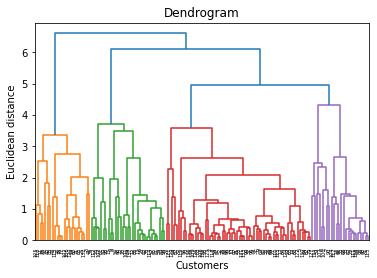

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(Xs[[x for x in Xs.columns if x != "cl"]], method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

##### Clustering aglomerativo

In [ ]:
cluster = AgglomerativeClustering(linkage="ward", n_clusters=4)

##### Perfilamiento

In [ ]:
X_users["cl"] = Xs["cl"] = Xm["cl"] = [str(x) for x in cluster.fit_predict(Xs[[x for x in Xs.columns if x != "cl"]])]

In [ ]:
Xm.iplot(kind = "scatter", mode = "markers", x="d1", y = "d2", categories="cl")

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [ ]:
X_users["cl"].value_counts(True)

1   0.43
2   0.22
0   0.17
3   0.17
Name: cl, dtype: float64

In [ ]:
aux = X_users[["cl"]].reset_index().merge(users[["userID"]+ls_disc_users], on ="userID", how = "inner")

In [ ]:
aux

,userID,cl,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,interest,personality,religion,activity,color,budget
0,U1001,2,false,abstemious,informal,family,on foot,single,independent,variety,thrifty-protector,none,student,black,medium
1,U1002,1,false,abstemious,informal,family,public,single,independent,technology,hunter-ostentatious,Catholic,student,red,low
2,U1003,1,false,social drinker,formal,family,public,single,independent,none,hard-worker,Catholic,student,blue,low
3,U1004,3,false,abstemious,informal,family,public,single,independent,variety,hard-worker,none,professional,green,medium
4,U1005,2,false,abstemious,no preference,family,public,single,independent,none,thrifty-protector,Catholic,student,black,medium
5,U1006,1,true,social drinker,no preference,friends,car owner,single,independent,variety,hard-worker,none,student,blue,medium
6,U1007,2,false,casual drinker,informal,solitary,public,single,independent,variety,thrifty-protector,Catholic,student,purple,low
7,U1008,0,false,social drinker,formal,solitary,public,single,independent,technology,hard-worker,Catholic,student,green,low
8,U1009,0,false,abstemious,formal,family,on foot,single,kids,variety,thrifty-protector,Catholic,student,green,medium
9,U1010,1,false,social drinker,no preference,friends,car owner,married,kids,technology,hard-worker,none,student,green,medium


In [ ]:
X_users.groupby("cl").mean()

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating
cl,,,,,,,,,,,,,,,,
0,"1,989.04",61.83,1.68,0.21,0.33,0.83,6.25,0.21,0.04,0.08,0.04,0.00,1.00,0.50,0.54,0.46
1,"1,983.70",62.73,1.65,0.00,0.00,0.97,0.08,0.00,0.00,0.00,0.00,0.00,0.92,1.34,1.32,1.22
2,"1,987.55",72.81,1.71,0.19,0.00,0.10,1.13,0.13,0.00,0.03,0.26,0.00,1.00,1.24,1.29,1.09
3,"1,978.96",62.91,1.65,0.00,0.04,0.70,0.61,0.00,0.09,0.04,0.35,0.96,0.91,1.46,1.60,1.42


In [ ]:
X_users.mean().to_frame().T

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating,cl
0,"1,984.70",64.87,1.67,0.08,0.07,0.70,1.48,0.07,0.02,0.03,0.12,0.16,0.95,1.19,1.22,1.09,"1,531,313,044,298,704,436,140,209,303,001,540,7..."


In [ ]:
pivot_categories(df=aux, cluster_column="cl", categories=ls_disc_users)

,smoker_?,smoker_false,smoker_true,drink_level_abstemious,drink_level_casual drinker,drink_level_social drinker,dress_preference_?,dress_preference_elegant,dress_preference_formal,dress_preference_informal,dress_preference_no preference,ambience_?,ambience_family,ambience_friends,ambience_solitary,transport_?,transport_car owner,transport_on foot,transport_public,marital_status_?,marital_status_married,marital_status_single,marital_status_widow,hijos_?,hijos_dependent,hijos_independent,hijos_kids,interest_eco-friendly,interest_none,interest_retro,interest_technology,interest_variety,personality_conformist,personality_hard-worker,personality_hunter-ostentatious,personality_thrifty-protector,religion_Catholic,religion_Christian,religion_Jewish,religion_Mormon,religion_none,activity_?,activity_professional,activity_student,activity_unemployed,activity_working-class,color_black,color_blue,color_green,color_orange,color_purple,color_red,color_white,color_yellow,budget_?,budget_high,budget_low,budget_medium
cl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.88,0.77,0.29,0.75,0.79,0.00,0.00,0.29,0.52,0.91,0.00,0.46,0.59,0.83,0.04,0.17,0.21,0.97,0.00,0.04,1.00,0.00,0.08,0.05,0.85,0.75,0.12,0.14,0.00,0.33,0.95,0.00,0.38,0.13,0.96,0.75,0.15,0.00,0.00,0.85,0.04,0.04,0.95,0.49,0.00,0.17,0.25,0.32,0.00,0.28,0.37,0.56,0.34,0.04,0.00,0.30,0.98
1,0.05,0.79,0.93,0.37,0.55,0.95,0.07,0.02,0.44,0.48,0.94,0.08,0.58,0.76,0.78,0.08,0.24,0.12,0.99,0.07,0.04,1.00,0.00,0.12,0.00,0.96,0.65,0.13,0.31,0.03,0.42,0.96,0.07,0.57,0.12,0.97,0.70,0.21,0.00,0.07,0.93,0.08,0.00,1.00,0.00,0.00,0.17,0.38,0.29,0.04,0.14,0.32,0.45,0.77,0.10,0.04,0.40,0.98
2,0.00,0.77,0.90,0.39,0.41,0.93,0.03,0.03,0.21,0.26,0.97,0.03,0.43,0.74,0.77,0.03,0.27,0.18,0.97,0.00,0.06,0.93,0.67,0.03,0.07,0.96,0.49,0.06,0.31,0.25,0.26,0.93,0.10,0.36,0.22,0.95,0.68,0.00,0.00,0.00,0.94,0.00,0.13,0.96,0.48,0.00,0.16,0.42,0.13,0.07,0.39,0.24,0.16,0.72,0.00,0.03,0.20,0.99
3,0.00,0.83,0.83,0.43,0.37,0.91,0.00,0.09,0.19,0.29,0.95,0.00,0.61,0.73,0.60,0.00,0.43,0.07,0.96,0.00,0.22,0.99,0.00,0.04,0.00,0.77,0.86,0.13,0.10,0.00,0.60,0.89,0.00,0.43,0.22,0.94,0.78,0.35,0.24,0.00,0.59,0.04,0.45,0.88,0.00,0.42,0.09,0.47,0.26,0.23,0.00,0.57,0.28,0.35,0.00,0.09,0.05,0.99


In [ ]:
X_users.groupby("cl").mean().merge(pivot_categories(df=aux, cluster_column="cl", categories=ls_disc_users), left_index=True, right_index=True)

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating,smoker_?,smoker_false,smoker_true,drink_level_abstemious,drink_level_casual drinker,drink_level_social drinker,dress_preference_?,dress_preference_elegant,dress_preference_formal,dress_preference_informal,dress_preference_no preference,ambience_?,ambience_family,ambience_friends,ambience_solitary,transport_?,transport_car owner,transport_on foot,transport_public,marital_status_?,marital_status_married,marital_status_single,marital_status_widow,hijos_?,hijos_dependent,hijos_independent,hijos_kids,interest_eco-friendly,interest_none,interest_retro,interest_technology,interest_variety,personality_conformist,personality_hard-worker,personality_hunter-ostentatious,personality_thrifty-protector,religion_Catholic,religion_Christian,religion_Jewish,religion_Mormon,religion_none,activity_?,activity_professional,activity_student,activity_unemployed,activity_working-class,color_black,color_blue,color_green,color_orange,color_purple,color_red,color_white,color_yellow,budget_?,budget_high,budget_low,budget_medium
cl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,"1,989.04",61.83,1.68,0.21,0.33,0.83,6.25,0.21,0.04,0.08,0.04,0.00,1.00,0.50,0.54,0.46,0.00,0.88,0.77,0.29,0.75,0.79,0.00,0.00,0.29,0.52,0.91,0.00,0.46,0.59,0.83,0.04,0.17,0.21,0.97,0.00,0.04,1.00,0.00,0.08,0.05,0.85,0.75,0.12,0.14,0.00,0.33,0.95,0.00,0.38,0.13,0.96,0.75,0.15,0.00,0.00,0.85,0.04,0.04,0.95,0.49,0.00,0.17,0.25,0.32,0.00,0.28,0.37,0.56,0.34,0.04,0.00,0.30,0.98
1,"1,983.70",62.73,1.65,0.00,0.00,0.97,0.08,0.00,0.00,0.00,0.00,0.00,0.92,1.34,1.32,1.22,0.05,0.79,0.93,0.37,0.55,0.95,0.07,0.02,0.44,0.48,0.94,0.08,0.58,0.76,0.78,0.08,0.24,0.12,0.99,0.07,0.04,1.00,0.00,0.12,0.00,0.96,0.65,0.13,0.31,0.03,0.42,0.96,0.07,0.57,0.12,0.97,0.70,0.21,0.00,0.07,0.93,0.08,0.00,1.00,0.00,0.00,0.17,0.38,0.29,0.04,0.14,0.32,0.45,0.77,0.10,0.04,0.40,0.98
2,"1,987.55",72.81,1.71,0.19,0.00,0.10,1.13,0.13,0.00,0.03,0.26,0.00,1.00,1.24,1.29,1.09,0.00,0.77,0.90,0.39,0.41,0.93,0.03,0.03,0.21,0.26,0.97,0.03,0.43,0.74,0.77,0.03,0.27,0.18,0.97,0.00,0.06,0.93,0.67,0.03,0.07,0.96,0.49,0.06,0.31,0.25,0.26,0.93,0.10,0.36,0.22,0.95,0.68,0.00,0.00,0.00,0.94,0.00,0.13,0.96,0.48,0.00,0.16,0.42,0.13,0.07,0.39,0.24,0.16,0.72,0.00,0.03,0.20,0.99
3,"1,978.96",62.91,1.65,0.00,0.04,0.70,0.61,0.00,0.09,0.04,0.35,0.96,0.91,1.46,1.60,1.42,0.00,0.83,0.83,0.43,0.37,0.91,0.00,0.09,0.19,0.29,0.95,0.00,0.61,0.73,0.60,0.00,0.43,0.07,0.96,0.00,0.22,0.99,0.00,0.04,0.00,0.77,0.86,0.13,0.10,0.00,0.60,0.89,0.00,0.43,0.22,0.94,0.78,0.35,0.24,0.00,0.59,0.04,0.45,0.88,0.00,0.42,0.09,0.47,0.26,0.23,0.00,0.57,0.28,0.35,0.00,0.09,0.05,0.99


In [ ]:
X_users.groupby("cl").mean().merge(pivot_categories(df=aux, cluster_column="cl", categories=ls_disc_users), left_index=True, right_index=True).style.background_gradient(cmap='Blues')

,birth_year,weight,height,American,Cafeteria,Mexican,Otros,Pizzeria,American_Express,MasterCard-Eurocard,VISA,bank_debit_cards,cash,rating,food_rating,service_rating,smoker_?,smoker_false,smoker_true,drink_level_abstemious,drink_level_casual drinker,drink_level_social drinker,dress_preference_?,dress_preference_elegant,dress_preference_formal,dress_preference_informal,dress_preference_no preference,ambience_?,ambience_family,ambience_friends,ambience_solitary,transport_?,transport_car owner,transport_on foot,transport_public,marital_status_?,marital_status_married,marital_status_single,marital_status_widow,hijos_?,hijos_dependent,hijos_independent,hijos_kids,interest_eco-friendly,interest_none,interest_retro,interest_technology,interest_variety,personality_conformist,personality_hard-worker,personality_hunter-ostentatious,personality_thrifty-protector,religion_Catholic,religion_Christian,religion_Jewish,religion_Mormon,religion_none,activity_?,activity_professional,activity_student,activity_unemployed,activity_working-class,color_black,color_blue,color_green,color_orange,color_purple,color_red,color_white,color_yellow,budget_?,budget_high,budget_low,budget_medium
cl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1989.041667,61.833333,1.680833,0.208333,0.333333,0.833333,6.250000,0.208333,0.041667,0.083333,0.041667,0.000000,1.000000,0.497648,0.540329,0.463746,0.000000,0.875000,0.774194,0.291667,0.751807,0.793104,0.000000,0.000000,0.291667,0.520482,0.907838,0.000000,0.458333,0.594427,0.826069,0.041667,0.173599,0.208168,0.972546,0.000000,0.041667,0.998192,0.000000,0.083333,0.045283,0.851925,0.753666,0.125000,0.142012,0.000000,0.328461,0.952723,0.000000,0.375000,0.130081,0.962601,0.750000,0.148148,0.000000,0.000000,0.847724,0.041667,0.043400,0.950869,0.491175,0.000000,0.166667,0.247934,0.324368,0.000000,0.279356,0.374143,0.556332,0.339121,0.041667,0.000000,0.303797,0.978865
1,1983.700000,62.733333,1.645167,0.000000,0.000000,0.966667,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.916667,1.340393,1.316472,1.215845,0.050000,0.788782,0.934668,0.366667,0.547350,0.948978,0.066667,0.017836,0.435694,0.475885,0.941393,0.083333,0.580938,0.760640,0.778221,0.083333,0.236006,0.118149,0.988314,0.066667,0.035672,0.998108,0.000000,0.116667,0.000000,0.960151,0.650022,0.133333,0.306905,0.027442,0.422920,0.957368,0.066667,0.570749,0.121766,0.965110,0.700000,0.213904,0.000000,0.067052,0.929836,0.083333,0.000000,0.998487,0.000000,0.000000,0.166667,0.378738,0.285303,0.043801,0.137146,0.315596,0.450205,0.771461,0.100000,0.036969,0.402785,0.982887
2,1987.548387,72.806452,1.710323,0.193548,0.000000,0.096774,1.129032,0.129032,0.000000,0.032258,0.258065,0.000000,1.000000,1.236424,1.291944,1.091720,0.000000,0.774194,0.900415,0.387097,0.412646,0.932224,0.032258,0.033298,0.206430,0.257821,0.969777,0.032258,0.432868,0.744340,0.767833,0.032258,0.266380,0.179383,0.974130,0.000000,0.064516,0.928968,0.668118,0.032258,0.066595,0.960893,0.485497,0.064516,0.309656,0.245409,0.256089,0.926264,0.096774,0.355913,0.216771,0.954364,0.677419,0.000000,0.000000,0.000000,0.936556,0.000000,0.129032,0.958383,0.479061,0.000000,0.161290,0.420469,0.128355,0.072939,0.391143,0.244672,0.155791,0.717533,0.000000,0.032258,0.199785,0.990424
3,1978.956522,62.913043,1.654348,0.000000,0.043478,0.695652,0.608696,0.000000,0.086957,0.043478,0.347826,0.956522,0.913043,1.463550,1.602447,1.421891,0.000000,0.826087,0.828829,0.434783,0.372168,0.908373,0.000000,0.086957,0.189691,0.289408,0.954954,0.000000,0.608696,0.728507,0.599304,0.000000,0.434783,0.074434,0.959293,0.000000,0.217391,0.988067,0.000000,0.043478,0.000000,0.771203,0.859892,0.130435,0.099352,0.000000,0.603408,0.893633,0.000000,0.434783,0.223301,0.938255,0.782609,0.345865,0.242220,0.000000,0.593350,0.043478,0.453649,0.880202,0.000000,0.420640,0.086957,0.474227,0.259489,0.226740,0.000000,0.567584,0.276625,0.345827,0.000000,0.086957,0.047423,0.993326


### Clustering de restaurantes

#### TAD

In [ ]:
X_restaurant = restaurant_payment.merge(restaurant_rating, on ="placeID", how = "outer").merge(restaruants_cuisine, on = "placeID", how = "outer").merge(restaurants[["placeID"]], on = "placeID", how = "right").fillna(0).set_index("placeID")

In [ ]:
X_restaurant

,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,American,Dutch-Belgian,International,Italian,Mexican,Otros
placeID,,,,,,,,,,,,,,,
134999,0.00,0.00,0.00,0.00,0.00,0.00,1.60,1.60,1.60,0.00,0.00,0.00,0.00,0.00,1.00
132825,0.00,0.00,1.00,0.00,0.00,0.00,1.28,1.34,0.94,0.00,0.00,0.00,0.00,1.00,0.00
135106,0.00,0.00,1.00,1.00,0.00,1.00,1.20,1.20,1.20,0.00,0.00,0.00,0.00,1.00,0.00
132667,0.00,0.00,1.00,0.00,0.00,0.00,1.25,2.00,1.25,0.00,0.00,0.00,0.00,0.00,1.00
132613,0.00,0.00,1.00,0.00,0.00,0.00,1.17,1.33,1.00,0.00,0.00,0.00,0.00,1.00,0.00
135040,0.00,0.00,1.00,1.00,0.00,1.00,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00
132732,0.00,0.00,1.00,0.00,0.00,0.00,0.62,0.88,1.00,0.00,0.00,0.00,0.00,1.00,0.00
132875,1.00,1.00,1.00,1.00,0.00,1.00,1.12,1.25,1.12,0.00,0.00,0.00,0.00,0.00,1.00
132609,0.00,0.00,1.00,0.00,0.00,0.00,0.60,0.60,0.60,0.00,0.00,0.00,0.00,0.00,1.00


#### Clustering

##### Escalamiento

In [ ]:
sc = MinMaxScaler()

In [ ]:
Xs = pd.DataFrame(columns=X_restaurant.columns, index=X_restaurant.index, data = sc.fit_transform(X_restaurant))

##### Visualización

In [ ]:
mds = MDS(n_components=2)

In [ ]:
Xm = pd.DataFrame(columns=["d1", "d2"], data=mds.fit_transform(Xs), index = X_restaurant.index)

In [ ]:
Xm.iplot(kind="scatter", mode="markers", x="d1", y="d2")

##### Clustering jerárquico aglomerativo

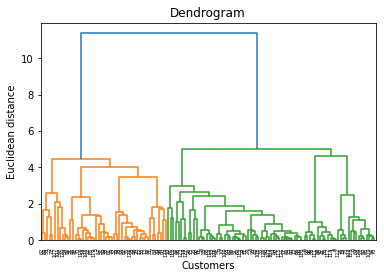

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(Xs, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, linkage="ward")

##### Perfilamiento

In [ ]:
X_restaurant["cl"] = Xs["cl"] = Xm["cl"] = [str(x) for x in cluster.fit_predict(Xs)]

In [ ]:
aux = X_restaurant[["cl"]].reset_index().merge(restaurants[["placeID"]+ls_disc], on ="placeID", how = "inner")

In [ ]:
Xm.iplot(kind="scatter", mode="markers", x="d1", y="d2", categories="cl")

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/oscar/VirtualEnvs/Python 3/lib/python3.7/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [ ]:
X_restaurant.groupby("cl").mean().style.background_gradient(cmap='Blues')

,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,American,Dutch-Belgian,International,Italian,Mexican,Otros
cl,,,,,,,,,,,,,,,
0,0.037037,0.037037,0.802469,0.000000,0.000000,0.024691,1.129071,1.170331,1.025860,0.037037,0.000000,0.037037,0.037037,0.209877,0.506173
1,0.489796,0.204082,0.979592,0.938776,0.061224,1.000000,1.263185,1.285961,1.184883,0.040816,0.000000,0.020408,0.020408,0.224490,0.612245


In [ ]:
X_restaurant.mean().to_frame().T

,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,American,Dutch-Belgian,International,Italian,Mexican,Otros,cl
0,0.21,0.10,0.87,0.35,0.02,0.39,1.18,1.21,1.09,0.04,0.00,0.03,0.03,0.22,0.55,"77,000,769,239,307,693,493,199,250,802,625,083,..."


In [ ]:
X_restaurant.groupby("cl").mean().merge(pivot_categories(df=aux, categories=ls_disc, cluster_column="cl"), left_index = True, right_index=True).style.background_gradient(cmap='Blues')

,american_express,bank_debit_cards,cash,mastercard-eurocard,otros,visa,rating,food_rating,service_rating,American,Dutch-Belgian,International,Italian,Mexican,Otros,alcohol_Full_Bar,alcohol_No_Alcohol_Served,alcohol_Wine-Beer,smoking_area_none,smoking_area_not permitted,smoking_area_only at bar,smoking_area_permitted,smoking_area_section,dress_code_casual,dress_code_formal,dress_code_informal,accessibility_completely,accessibility_no_accessibility,accessibility_partially,price_high,price_low,price_medium,Rambience_familiar,Rambience_quiet,franchise_f,franchise_t,area_closed,area_open,other_services_Internet,other_services_none,other_services_variety
cl,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.037037,0.037037,0.802469,0.000000,0.000000,0.024691,1.129071,1.170331,1.025860,0.037037,0.000000,0.037037,0.037037,0.209877,0.506173,0.024691,0.822528,0.942938,0.592593,0.535832,0.062002,0.526647,0.777497,0.086420,0.026996,0.998427,0.432099,0.883010,0.791752,0.037037,0.525392,0.985027,0.901235,0.898752,0.876543,0.919410,0.851852,0.933718,0.037037,0.973897,0.664246
1,0.489796,0.204082,0.979592,0.938776,0.061224,1.000000,1.263185,1.285961,1.184883,0.040816,0.000000,0.020408,0.020408,0.224490,0.612245,0.142857,0.522034,0.967825,0.448980,0.255019,0.048300,0.050627,0.957298,0.061224,0.000000,0.998671,0.204082,0.892764,0.784799,0.448980,0.145725,0.974795,0.979592,0.505155,0.755102,0.940800,0.938776,0.761658,0.020408,0.895453,0.845186


### Solución compuesta

In [ ]:
cl_users = X_users.reset_index()[["userID", "cl"]].rename(columns={"cl": "cl_user"})

In [ ]:
cl_users

,userID,cl_user
0,U1001,2
1,U1002,1
2,U1003,1
3,U1004,3
4,U1005,2
5,U1006,1
6,U1007,2
7,U1008,0
8,U1009,0
9,U1010,1


In [ ]:
cl_restaurants = X_restaurant.reset_index()[["placeID", "cl"]].rename(columns={"cl": "cl_restaurants"})

In [ ]:
cl_restaurants

,placeID,cl_restaurants
0,134999,0
1,132825,0
2,135106,1
3,132667,0
4,132613,0
5,135040,1
6,132732,0
7,132875,1
8,132609,0
9,135082,0


In [ ]:
rating

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


In [ ]:
cl_ratings = rating.merge(cl_users, on ="userID", how = "inner").merge(cl_restaurants, on ="placeID", how ="inner")

In [ ]:
cl_ratings

,userID,placeID,rating,food_rating,service_rating,cl_user,cl_restaurants
0,U1077,135085,2,2,2,3,0
1,U1108,135085,1,2,1,0,0
2,U1081,135085,1,2,1,1,0
3,U1001,135085,0,1,1,2,0
4,U1056,135085,2,2,2,1,0
...,...,...,...,...,...,...,...
1156,U1006,132922,2,1,2,1,0
1157,U1003,132937,2,2,1,1,0
1158,U1027,132937,1,1,1,2,0
1159,U1029,132937,1,1,1,1,0


In [ ]:
rating.shape

(1161, 5)

In [ ]:
cl_ratings[["rating", "food_rating", "service_rating"]].describe()

,rating,food_rating,service_rating
count,"1,161.00","1,161.00","1,161.00"
mean,1.20,1.22,1.09
std,0.77,0.79,0.79
min,0.00,0.00,0.00
25%,1.00,1.00,0.00
50%,1.00,1.00,1.00
75%,2.00,2.00,2.00
max,2.00,2.00,2.00


In [ ]:
cl_ratings.pivot_table(index = "cl_user", columns="cl_restaurants", values = ["rating", "food_rating", "service_rating"], aggfunc="mean").style.background_gradient(cmap='Blues')

In [ ]:
cl_ratings.groupby("cl_restaurants").mean()

,placeID,rating,food_rating,service_rating
cl_restaurants,,,,
0,"133,925.56",1.17,1.20,1.04
1,"134,614.61",1.25,1.25,1.16


In [ ]:
cl_ratings.groupby("cl_user").mean()

,placeID,rating,food_rating,service_rating
cl_user,,,,
0,"133,994.00",0.49,0.52,0.44
1,"134,240.67",1.37,1.33,1.24
2,"134,180.31",1.23,1.29,1.09
3,"134,291.75",1.46,1.58,1.40
